In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import sys
import os
print(sys.path)

['/home/michal/PycharmProjects/tfx-titanic-training', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/michal/venv/ML-3.8/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/michal/venv/ML-3.8/lib/python3.8/site-packages/IPython/extensions', '/home/michal/.ipython']


In [3]:
import importlib
import tfx_utils
import utils

importlib.reload(tfx_utils)
importlib.reload(utils)

<module 'utils' from '/home/michal/PycharmProjects/tfx-titanic-training/utils.py'>

### Setup

#### Validate package version installation

In [4]:
!python -c "import tfx; print('TFX version: {}'.format(tfx.__version__))"
!python -c "import kfp; print('KFP version: {}'.format(kfp.__version__))"

TFX version: 0.25.0
KFP version: 1.0.4


## Setup local path to data, train, test folders 

In [6]:
import os
from pathlib import Path

notebook_path=os.getcwd()
local_data_dirpath = os.path.join(notebook_path, 'data')

local_train_dirpath = os.path.join(local_data_dirpath, "train")
local_train_filepath = os.path.join(local_train_dirpath, "train.csv")
local_test_dirpath = os.path.join(local_data_dirpath, "test")
local_test_filepath = os.path.join(local_test_dirpath, "test.csv")


In [52]:
from ml_metadata import metadata_store
from ml_metadata.proto import metadata_store_pb2

import os
import json

import ml_metadata
import tensorflow_data_validation as tfdv
import tensorflow_model_analysis as tfma


from ml_metadata.metadata_store import metadata_store
from ml_metadata.proto import metadata_store_pb2

from tfx.orchestration import metadata
from tfx.types import standard_artifacts

from tensorflow.python.lib.io import file_io


# path to metadata.db

#METADATA_STORE = f'{notebook_path}/pipeline/tests/resources/20210425_225924/tfx_metadata/tfx-titanic-training/metadata.db'



def _make_default_sqlite_uri(pipeline_name):
    return os.path.join(os.environ['HOME'], 'airflow/artifact-store/pipelines', pipeline_name, 'tfx_metadata', 
                        'metadata.db')

def get_metadata_store(pipeline_name):
    return tfx_utils.TFXReadonlyMetadataStore.from_sqlite_db(_make_default_sqlite_uri(pipeline_name))

pipeline_name = 'tfx-titanic-training'
pipeline_db_path = _make_default_sqlite_uri(pipeline_name)
print('Pipeline DB:\n{}'.format(pipeline_db_path))

store_wrapper = get_metadata_store(pipeline_name)

metadata_connection_config=metadata.sqlite_metadata_connection_config(pipeline_db_path)

store = metadata_store.MetadataStore(metadata_connection_config)


Pipeline DB:
/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/tfx_metadata/metadata.db
tensorboard_logdir: /home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/Trainer/model


Set environment variables

In [9]:
%cd {notebook_path}/pipeline

/home/michal/PycharmProjects/ml-gcp-pipeline/tfx_titanic_pipeline/pipeline


List the registered artifact types.

In [23]:
for artifact_type in store.get_artifact_types():
    print(artifact_type.name)

Examples
Schema
TransformGraph
TransformCache
ExampleStatistics
HyperParameters
ExampleAnomalies
Model
ModelRun
ModelEvaluation
ModelBlessing
InfraBlessing
PushedModel


Display the registered execution types.

In [24]:
for execution_type in store.get_execution_types():
    print(execution_type.name)

tfx.components.example_gen.csv_example_gen.component.CsvExampleGen
tfx.components.common_nodes.importer_node.ImporterNode
tfx.components.common_nodes.resolver_node.ResolverNode
tfx.components.transform.component.Transform
tfx.components.statistics_gen.component.StatisticsGen
tfx.components.tuner.component.Tuner
tfx.components.example_validator.component.ExampleValidator
tfx.components.schema_gen.component.SchemaGen
tfx.components.trainer.component.Trainer
tfx.components.evaluator.component.Evaluator
tfx.components.infra_validator.component.InfraValidator
tfx.components.pusher.component.Pusher


List the registered context types.

In [25]:
for context_type in store.get_context_types():
    print(context_type.name)

pipeline
run
component_run


## Visualizing TFX artifacts

### Retrieve data analysis and validation artifacts


Retrieve model artifacts

In [26]:
with metadata.Metadata(metadata_connection_config) as store:
    schema_artifacts = store.get_artifacts_by_type(standard_artifacts.Schema.TYPE_NAME)    
    stats_artifacts = store.get_artifacts_by_type(standard_artifacts.ExampleStatistics.TYPE_NAME)
    anomalies_artifacts = store.get_artifacts_by_type(standard_artifacts.ExampleAnomalies.TYPE_NAME)

### Visualize schema

In [38]:
schema_file = os.path.join(schema_artifacts[-1].uri, 'schema.pbtxt')
print("Generated schame file:{}".format(schema_file))

stats_path = stats_artifacts[-1].uri
train_stats_file = os.path.join(stats_path, 'train', 'stats_tfrecord')
eval_stats_file = os.path.join(stats_path, 'eval', 'stats_tfrecord')
print("Train stats file:{}, Eval stats file:{}".format(
    train_stats_file, eval_stats_file))

anomalies_path = anomalies_artifacts[-1].uri
train_anomalies_file = os.path.join(anomalies_path, 'train', 'anomalies.pbtxt')
eval_anomalies_file = os.path.join(anomalies_path, 'eval', 'anomalies.pbtxt')

print("Train anomalies file:{}, Eval anomalies file:{}".format(
    train_anomalies_file, eval_anomalies_file))

Generated schame file:/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/SchemaGen/schema/8/schema.pbtxt
Train stats file:/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/StatisticsGen/statistics/5/train/stats_tfrecord, Eval stats file:/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/StatisticsGen/statistics/5/eval/stats_tfrecord
Train anomalies file:/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/ExampleValidator/anomalies/7/train/anomalies.pbtxt, Eval anomalies file:/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/ExampleValidator/anomalies/7/eval/anomalies.pbtxt


In [39]:
schema = tfdv.load_schema_text(schema_file)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Embarked',STRING,required,,'Embarked'
'Sex',STRING,required,single,'Sex'
'Cabin',BYTES,required,,-
'Age',FLOAT,required,,-
'Fare',FLOAT,required,single,-
'Name',BYTES,required,single,-
'Parch',INT,required,single,-
'PassengerId',INT,required,single,-
'Pclass',INT,required,single,-


/home/michal/venv/ML-3.8/lib/python3.8/site-packages/tensorflow_data_validation/utils/display_util.py:151: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Values
Domain,
'Embarked',"'C', 'Q', 'S'"
'Sex',"'female', 'male'"


## Visualize statistics


In [40]:
train_stats = tfdv.load_statistics(train_stats_file)
eval_stats = tfdv.load_statistics(eval_stats_file)
tfdv.visualize_statistics(lhs_statistics=eval_stats, rhs_statistics=train_stats,
                          lhs_name='EVAL_DATASET', rhs_name='TRAIN_DATASET')

Visualize anomalies

In [41]:
train_anomalies = tfdv.load_anomalies_text(train_anomalies_file)
tfdv.display_anomalies(train_anomalies)

In [42]:
eval_anomalies = tfdv.load_anomalies_text(eval_anomalies_file)
tfdv.display_anomalies(eval_anomalies)

### Visualize model evaluations & hyperparameters

In [43]:
with metadata.Metadata(metadata_connection_config) as store:
    model_eval_artifacts = store.get_artifacts_by_type(standard_artifacts.ModelEvaluation.TYPE_NAME)
    hyperparam_artifacts = store.get_artifacts_by_type(standard_artifacts.HyperParameters.TYPE_NAME)
    
model_eval_path = model_eval_artifacts[-1].uri
print("Generated model evaluation result:{}".format(model_eval_path))
best_hparams_path = os.path.join(hyperparam_artifacts[-1].uri, 'best_hyperparameters.txt')
print("Generated model best hyperparameters result:{}".format(best_hparams_path))

Generated model evaluation result:/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/Evaluator/evaluation/10
Generated model best hyperparameters result:/home/michal/airflow/artifact-store/pipelines/tfx-titanic-training/Tuner/best_hyperparameters/6/best_hyperparameters.txt


### Return best hyperparameters

In [41]:
# Latest pipeline run Tuner search space.
json.loads(file_io.read_file_to_string(best_hparams_path))['space']

[{'class_name': 'Float',
  'config': {'name': 'learning_rate',
   'default': 0.0009167702421017742,
   'conditions': [],
   'min_value': 0.0001,
   'max_value': 0.01,
   'step': None,
   'sampling': 'log'}},
 {'class_name': 'Int',
  'config': {'name': 'n_layers',
   'default': 2,
   'conditions': [],
   'min_value': 1,
   'max_value': 2,
   'step': 1,
   'sampling': None}},
 {'class_name': 'Int',
  'config': {'name': 'n_units_1',
   'default': 72,
   'conditions': [{'class_name': 'Parent',
     'config': {'name': 'n_layers', 'values': [1]}}],
   'min_value': 8,
   'max_value': 128,
   'step': 8,
   'sampling': None}},
 {'class_name': 'Int',
  'config': {'name': 'n_units_1',
   'default': 128,
   'conditions': [{'class_name': 'Parent',
     'config': {'name': 'n_layers', 'values': [2]}}],
   'min_value': 8,
   'max_value': 128,
   'step': 8,
   'sampling': None}},
 {'class_name': 'Int',
  'config': {'name': 'n_units_2',
   'default': 80,
   'conditions': [{'class_name': 'Parent',
     '

In [44]:
# Latest pipeline run Tuner searched best_hyperparameters artifacts.
json.loads(file_io.read_file_to_string(best_hparams_path))['values']

{'learning_rate': 0.008280949948794046,
 'n_layers': 2,
 'n_units_1': 48,
 'n_units_2': 80}

In [45]:
eval_result = tfma.load_eval_result(model_eval_path)
tfma.view.render_slicing_metrics(
    eval_result, slicing_column='Sex')

SlicingMetricsViewer(config={'weightedExamplesColumn': 'example_count'}, data=[{'slice': 'Sex:male', 'metrics'…

## Data Validation using store wrapper ( TFXReadonlyMetadataStore ) 

Print out the data artifacts:

In [21]:
# Visualize properties of example artifacts
store_wrapper.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.EXAMPLES)

,URI,SPLIT_NAMES,INPUT_FINGERPRINT,STATE,SPAN,PAYLOAD_FORMAT,NAME,PRODUCER_COMPONENT
ID,,,,,,,,
1,/home/michal/airflow/artifact-store/pipelines/...,"[""train"", ""eval""]","split:single_split,num_files:1,total_bytes:603...",published,0,FORMAT_TF_EXAMPLE,-,-
4,/home/michal/airflow/artifact-store/pipelines/...,"[""train"", ""eval""]",-,published,-,-,transformed_examples,Transform


Plot the artifact lineage:

<IPython.core.display.Javascript object>


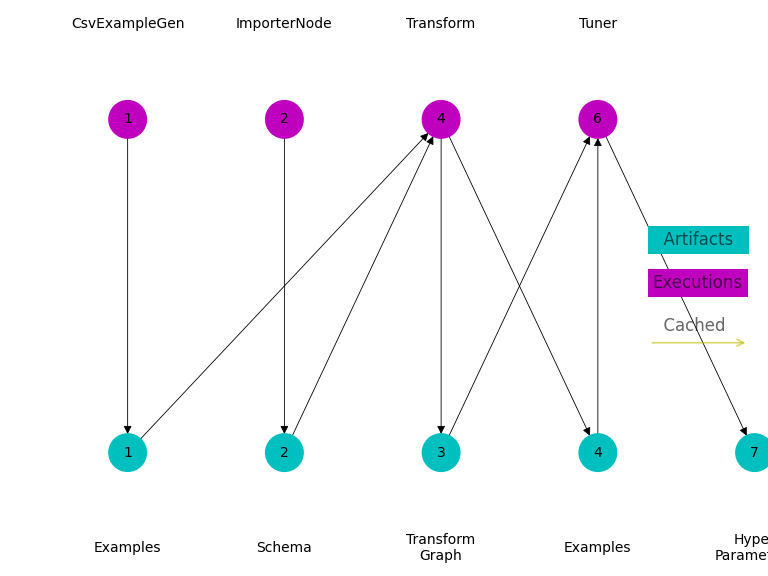

In [17]:
# Try different IDs here. Click stop in the plot when changing IDs.
%matplotlib notebook
store_wrapper.plot_artifact_lineage(7)

Print out the model artifacts:

In [9]:
store_wrapper.get_artifacts_of_type_df(tfx_utils.TFXArtifactTypes.MODEL)

,URI,STATE,PRODUCER_COMPONENT,NAME
ID,,,,
10,/home/michal/airflow/artifact-store/pipelines/...,published,Trainer,model


Analyze the model performance:

In [18]:
store_wrapper.display_tfma_analysis(2, slicing_column='Sex')

SlicingMetricsViewer(config={'weightedExamplesColumn': 'example_count'}, data=[{'slice': 'Sex:male', 'metrics'…

### Display example stats using store wrapper

In [51]:
# id of component has to be guessed
store_wrapper.display_examples_stats_for_model(6)

Now plot the artifact lineage:

<IPython.core.display.Javascript object>


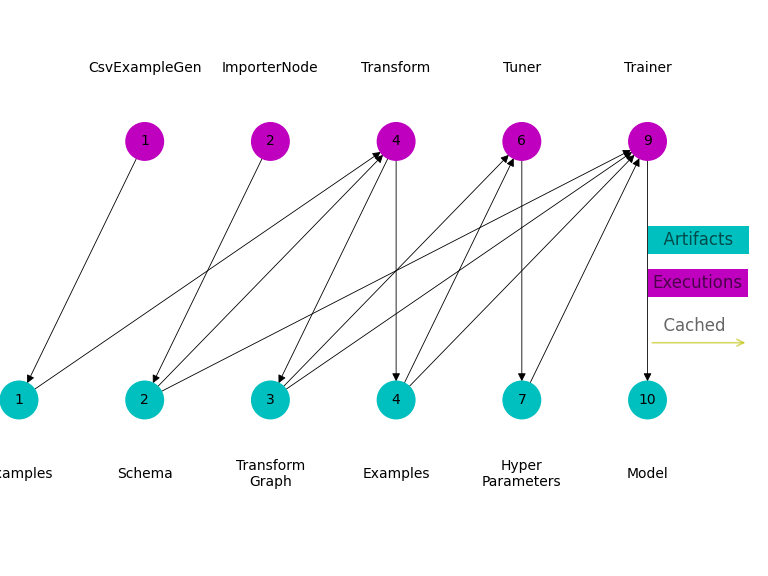

In [11]:
# Try different IDs here. Click stop in the plot when changing IDs.
%matplotlib notebook
store_wrapper.plot_artifact_lineage(10)